In [6]:
import os
import gym
import torch
import random
import pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from numpy.random import choice
import torch.nn.functional as F
from collections import namedtuple
from skimage.transform import resize 

In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install matplotlib
#!pip install scikit-image
#!pip install gym[atari,accept-rom-license]

In [7]:
torch.cuda.is_available()

True

In [47]:
env = gym.make('AlienDeterministic-v4', render_mode='rgb_array')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    env.seed(seed)
    np.random.seed(seed)

In [73]:
def downscale_obs(obs, new_size=(42,42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2) #B
    else:
        return resize(obs, new_size, anti_aliasing=True)

def prepare_state(state): 
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

def prepare_multi_state(state1, state2): 
    state1 = state1.clone()
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = state1[0][3]
    state1[0][3] = tmp
    return state1

def prepare_initial_state(state, N=4): 
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
    tmp = state_.repeat((N, 1, 1))
    return tmp.unsqueeze(dim=0)
     
def init_func(eps_start, scores_len, action_size, BUFFER_SIZE, BATCH_SIZE, state_size, LR, UPDATE_EVERY, GAMMA, TAU, DQN, prio, ICM):
    tot_t = 0    
    reward = 0.
    scores = [] 
    eps = eps_start
    scores_window = deque(maxlen=scores_len)
    agent = Agent(state_size, action_size, BUFFER_SIZE, BATCH_SIZE, LR, UPDATE_EVERY, GAMMA, TAU, DQN, prio, ICM) 
    return (tot_t, reward, scores, eps, scores_window, agent)

def reset_episode(stack_size, seed):
    env.reset(seed=seed)
    state = prepare_initial_state(env.render())
    state_dq = deque(maxlen=stack_size)
    for _ in range(stack_size):
        state_dq.append(prepare_state(env.render()))
    score = 0
    return (state, state_dq, score)

def printer(scores_window, scores, score, i_episode, tot_t, scores_len, la, agent, memory, eps, seed, prio, save):
    checkpoint_name = ''
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    print('\rEpisode {}\tAverage Score: {:.2f} {}'.format(i_episode, np.mean(scores_window), la), end="")
    if i_episode % scores_len == 0:
        print('\rEpisode {}\tAverage Score: {:.2f} {}'.format(i_episode, np.mean(scores_window), tot_t))
        seed_everything(seed)
        if save:
            save_ckp(checkpoint_name, i_episode, agent, memory, eps, scores_window, prio)


def create_checkpoint_name(seed, state_size, action_size, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY, stack_size, n_episodes, max_t, eps_start, eps_end, eps_decay, scores_len, DQN, prio):
    x = str(seed)+'_'+str(state_size)+'_'+str(action_size)+'_'+str(BUFFER_SIZE)+'_'+str(BATCH_SIZE)+'_'+str(GAMMA)+'_'+str(TAU)+'_'+str(LR)+'_'+str(UPDATE_EVERY)+'_'+str(stack_size)+'_'+str(n_episodes)+'_'+str(max_t)+'_'+str(eps_start)+'_'+str(eps_end)+'_'+str(eps_decay)+'_'+str(scores_len)
    if DQN:
        x += '_DQN'
    else:
        x += '_DDQN'
    if prio:
        x += '_prio'
    else:
        x += '_replay'
    return x


def avg(data):
    for i in range((len(data) + 10 - 1) // 10):
        sublist = data[i*10:(i+1)*10]
        yield sum(sublist) / len(sublist)

        
def save_ckp(checkpoint_name, i_episode, agent, my_memory, eps, scores_window, prio):
    f_path = 'saved_models/'+ checkpoint_name + '_' + str(i_episode)
    s_path = 'saved_models/a_to_b/' + checkpoint_name + ' ' + str(i_episode)
    checkpoint = {
        'eps': eps,
        'episodes': i_episode,
        'local_state_dict': agent.qnetwork_local.state_dict(),
        'target_state_dict': agent.qnetwork_target.state_dict(),
        'optimizer': agent.optimizer.state_dict(),
        't_step': agent.t_step
    }
    torch.save(checkpoint, f_path+'_models')
    a, b, c, d, e = zip(*my_memory.memory)
    pickle.dump(a, open(s_path+'_memory_a.pkl', 'wb'))
    pickle.dump(b, open(s_path+'_memory_b.pkl', 'wb'))
    pickle.dump(c, open(s_path+'_memory_c.pkl', 'wb'))
    pickle.dump(d, open(s_path+'_memory_d.pkl', 'wb'))
    pickle.dump(e, open(s_path+'_memory_e.pkl', 'wb'))
    pickle.dump(scores_window, open(f_path+'_scores.pkl', 'wb'))
    if prio:
        pickle.dump(my_memory.priorities, open(f_path+'_priorities.pkl', 'wb'))

def restore_memory(mem):
    aa = pickle.load(open('saved_models/0_4_18_100000_32_0.99_0.1_0.05_4_4_10_5000_1.0_0.01_0.995_5_1_DDQN_prio_5_memory_a.pkl', 'rb'))
    bb = pickle.load(open('saved_models/0_4_18_100000_32_0.99_0.1_0.05_4_4_10_5000_1.0_0.01_0.995_5_1_DDQN_prio_5_memory_b.pkl', 'rb'))
    cc = pickle.load(open('saved_models/0_4_18_100000_32_0.99_0.1_0.05_4_4_10_5000_1.0_0.01_0.995_5_1_DDQN_prio_5_memory_c.pkl', 'rb'))
    dd = pickle.load(open('saved_models/0_4_18_100000_32_0.99_0.1_0.05_4_4_10_5000_1.0_0.01_0.995_5_1_DDQN_prio_5_memory_d.pkl', 'rb'))
    ee = pickle.load(open('saved_models/0_4_18_100000_32_0.99_0.1_0.05_4_4_10_5000_1.0_0.01_0.995_5_1_DDQN_prio_5_memory_e.pkl', 'rb'))
    for a, b, c, d, e in zip(aa, bb, cc, dd, ee):
        mem.add(a,b,c,d,e)
    mem.priorities = pickle.load(open('saved_models/0_4_18_100000_32_0.99_0.1_0.05_4_4_10_5000_1.0_0.01_0.995_5_1_DDQN_prio_5_priorities.pkl', 'rb'))
    return mem

def restore_checkpoint(seed, state_size, action_size, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, LR, UPDATE_EVERY, 
                       stack_size, n_episodes, max_t, eps_start, eps_end, eps_decay, scores_len, DQN, prio, load, agent):
    checkpoint_name = create_checkpoint_name(seed, state_size, action_size, BUFFER_SIZE, BATCH_SIZE, GAMMA, TAU, 
                                             LR, UPDATE_EVERY, stack_size, n_episodes, max_t, eps_start, eps_end, eps_decay, scores_len, DQN, prio)
    if load:
        # memory = restore_memory(memory)
        checkpoint = torch.load('saved_models/0_4_18_100000_32_0.99_0.1_0.05_4_4_10_5000_1.0_0.01_0.995_5_1_DDQN_prio_5_models')
        scores_window = pickle.load(open('saved_models/0_4_18_100000_32_0.99_0.1_0.05_4_4_10_5000_1.0_0.01_0.995_5_1_DDQN_prio_5_scores.pkl', 'rb'))
        agent.qnetwork_local.load_state_dict(checkpoint['local_state_dict'])
        agent.qnetwork_target.load_state_dict(checkpoint['target_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer'])
        agent.t_step = checkpoint['t_step']
        eps = checkpoint['eps']
        start_at = checkpoint['episodes'] + 1
        seed_everything(seed)


# QNetwork

In [74]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=state_size, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.linear1 = nn.Linear(288,100)
        self.linear2 = nn.Linear(100,action_size)

    def forward(self, state):
        x = F.normalize(state)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y) 
        return y

# Replay Buffer

In [75]:
class ReplayBuffer: 
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones), None, None

    def __len__(self):
        return len(self.memory)

# Prioritized Replay Buffer

In [76]:
class PrioritizedReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=buffer_size)  
        self.priorities = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        self.priorities.append(max(self.priorities, default=1))
    
    def get_probabilities(self, priority_scale): # Pr(i) = pi^a / Σp^a 
        with torch.no_grad():
            scaled_priorities =  np.array(self.priorities) ** priority_scale
            sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities

    def get_importance(self, probabilities): # wi = (1/n * 1/pr(i)) ^ b
        importance = 1/len(self.memory) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized

    def sample(self, priority_scale=1.0):
        sample_size = min(len(self.memory), self.batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = choice(range(len(self.memory)), sample_size, p=sample_probs, replace=False)
        
        experiences = [self.memory[i] for i in sample_indices]
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        importance = self.get_importance(sample_probs[sample_indices])
        importance = torch.tensor(importance).float().to(device)
        return (states, actions, rewards, next_states, dones), importance, sample_indices


    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = float(abs(e).item() + offset)

    def __len__(self):
        return len(self.memory)

# ICM

In [77]:
class EncoderModel(nn.Module):
    def __init__(self):
        super(EncoderModel, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=(3,3), stride=2, padding=1) 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=2, padding=1)

    def forward(self,x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y)) 
        y = y.flatten(start_dim=1) 
        return y
        
class InverseModel(nn.Module):
    def __init__(self, input_size):
        super(InverseModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 18)

    def forward(self, state1, state2):
        x = torch.cat( (state1, state2) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y, dim=1)
        return y

class ForwardModel(nn.Module):
    def __init__(self):
        super(ForwardModel, self).__init__()
        self.linear1 = nn.Linear(306, 250)
        self.linear2 = nn.Linear(250, 288)

    def forward(self, state, action):
        action_ = torch.zeros(action.shape[0], 18).to(device)
        indices = torch.stack( (torch.arange(action.shape[0]).to(device), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.
        x = torch.cat( (state, action_) ,dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y

In [78]:
def loss_fn(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - 0.2) * inverse_loss
    loss_ += 0.2 * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + 0.1 * q_loss
    return loss

# Agent

In [79]:
class Agent():
    def __init__(self, state_size, action_size, BUFFER_SIZE, BATCH_SIZE, LR, UPDATE_EVERY, GAMMA, TAU, DQN, prio, ICM):
        self.state_size = state_size
        self.action_size = action_size
        self.UPDATE_EVERY = UPDATE_EVERY
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.TAU = TAU
        self.DQN = DQN
        self.prio = prio
        self.ICM = ICM

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.t_step = 0
        if prio:
            self.memory = PrioritizedReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        else:
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)

        if ICM:
            self.encoder = EncoderModel().to(device)
            self.forward_model = ForwardModel().to(device)
            self.inverse_model = InverseModel(576).to(device)
            self.forward_loss = nn.MSELoss(reduction='none').to(device)
            self.inverse_loss = nn.CrossEntropyLoss(reduction='none').to(device)
            self.qloss = nn.MSELoss().to(device)
            all_model_params = list(self.qnetwork_local.parameters()) + list(self.encoder.parameters()) #A
            all_model_params += list(self.forward_model.parameters()) + list(self.inverse_model.parameters())
            self.optimizer = optim.Adam(lr=LR, params=all_model_params)
        else:
            self.qnetwork_target = QNetwork(state_size, action_size).to(device)
            self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
            

    def act(self, state, eps=0.):
        state = state.to(device) 
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state) 
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()) 
        else:
            return random.choice(np.arange(self.action_size))


    def step_and_learn(self, state, action, reward, next_state, done, eps):
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > self.BATCH_SIZE:
                experiences, my_importance, my_indexes = self.memory.sample()
                states, actions, rewards, next_states, dones = experiences
                self.optimizer.zero_grad()

                if self.ICM:
                    forward_pred_err, inverse_pred_err = self.agentICM(states, actions, next_states)
                    reward = forward_pred_err.detach()
                    qvals = self.qnetwork_local(next_states) 
                    reward += 0.2 * torch.max(qvals)
                    reward_pred = self.qnetwork_local(states)
                    reward_target = reward_pred.clone()
                    indices = torch.stack( (torch.arange(actions.shape[0]).to(device), actions.squeeze()), dim=0)
                    indices = indices.tolist()
                    reward_target[indices] = reward.squeeze()
                    q_loss = 1e5 * self.qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
                    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err)
                else:
                    if self.DQN:
                        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
                    else:
                        Q_targets_b4 = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1) 
                        Q_targets_ne_2 = self.qnetwork_target(next_states).detach() 
                        Q_targets_next = (Q_targets_ne_2.gather(1, Q_targets_b4)) # Double DQN

                    Q_targets = rewards + (self.GAMMA * Q_targets_next * (1 - dones))
                    Q_expected = self.qnetwork_local(states).gather(1, actions) 
                    if self.prio:
                        error = Q_expected-Q_targets
                        loss = torch.mean(error**2 * my_importance**(1-eps))    
                        self.memory.set_priorities(errors=error, indices=my_indexes)
                    else:
                        loss = F.mse_loss(Q_expected, Q_targets)
                    
                loss.backward()
                self.optimizer.step()
                
                if not self.ICM:
                    # ------------------- update target network ------------------- #
                    for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
                        target_param.data.copy_(self.TAU*local_param.data + (1.0-self.TAU)*target_param.data) 


    def agentICM(self, state1, action, state2, forward_scale=1., inverse_scale=1e3):
        state1_hat = self.encoder(state1)
        state2_hat = self.encoder(state2)
        state2_hat_pred = self.forward_model(state1_hat.detach(), action.detach())
        forward_pred_err = forward_scale * self.forward_loss(state2_hat_pred, state2_hat.detach()).sum(dim=1).unsqueeze(dim=1)
        pred_action = self.inverse_model(state1_hat, state2_hat)
        inverse_pred_err = inverse_scale * self.inverse_loss(pred_action, action.detach().flatten()).unsqueeze(dim=1)
        return forward_pred_err, inverse_pred_err

# Main Function

In [90]:
def my_func(seed=42, state_size=4, action_size=18, BUFFER_SIZE=100000, BATCH_SIZE=32, 
            GAMMA=0.99, TAU=0.1, LR=0.05, UPDATE_EVERY=4, stack_size=4, n_episodes=1000, 
            max_t=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, scores_len=50, 
            DQN=False, prio=True, ICM=False, load= False, save=False):
    seed_everything(seed)
    start_at = 1
    tot_t, reward, scores, eps, scores_window, agent = init_func(eps_start, scores_len, action_size, BUFFER_SIZE, BATCH_SIZE, state_size, LR, UPDATE_EVERY, GAMMA, TAU, DQN, prio, ICM) 

    for i_episode in range(start_at, n_episodes+1):
        state, state_dq, score = reset_episode(stack_size, seed)
        for t in range(max_t):
            tot_t += 1

            # Agent act
            action = agent.act(state)
            
            # Env Step
            x = env.step(action)
            next_state, reward, done, _, _ = x # env.step(action)
            state_dq.append(prepare_state(next_state))
            next_state = torch.stack(list(state_dq),dim=1)
            
            # Add To Memory and move to Next State
            agent.memory.add(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
            agent.step_and_learn(state, action, reward, next_state, done, eps)
            if done:
                break 

        eps = max(eps_end, eps_decay*eps) 
        printer(scores_window, scores, score, i_episode, tot_t, scores_len, len(agent.memory), agent, agent.memory, eps, seed, prio, save)
    return agent, scores 

# AlienDeterministic

In [ ]:
my_agent1, my_scores1 = my_func(prio=False, DQN=False,n_episodes=1000, ICM=False, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

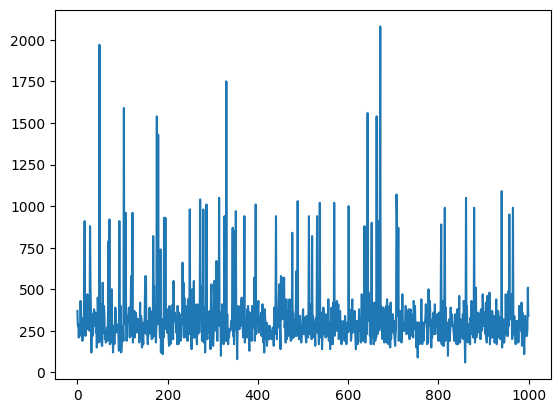

In [37]:
plt.plot(my_scores1)
plt.show() 

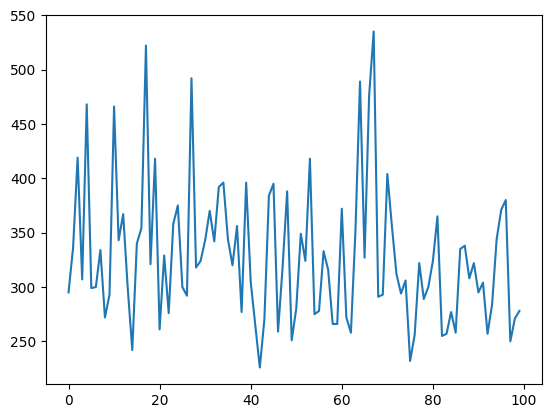

: 

In [39]:
x = [i for i in avg(my_scores1)]
plt.plot(x)
plt.show() 

In [13]:
my_agent2, my_scores2 = my_func(prio= False, DQN=False,n_episodes=1000, ICM=True, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 328.00 55256
Episode 200	Average Score: 388.60 116348
Episode 300	Average Score: 379.90 175489
Episode 400	Average Score: 366.80 234459
Episode 500	Average Score: 431.60 294352
Episode 600	Average Score: 382.30 353296
Episode 700	Average Score: 384.70 412056
Episode 800	Average Score: 401.10 471011
Episode 900	Average Score: 371.50 528348
Episode 1000	Average Score: 400.80 589929


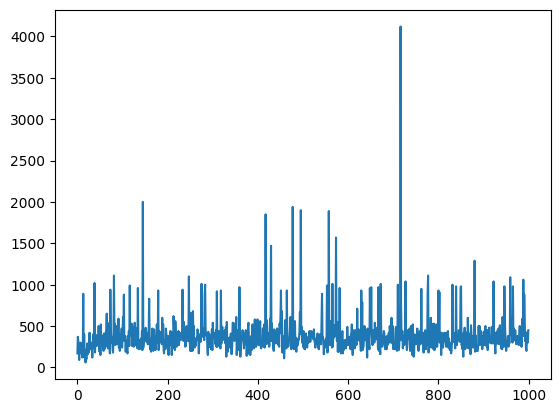

In [14]:
plt.plot(my_scores2)
plt.show() 

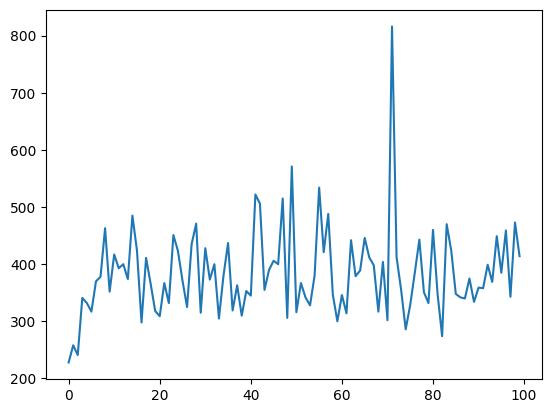

In [15]:
x = [i for i in avg(my_scores2)]
plt.plot(x)
plt.show() 

In [12]:
my_agent3, my_scores3 = my_func(prio= True, DQN=False,n_episodes=1000, ICM=False, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 178.90 53038
Episode 200	Average Score: 222.00 106605
Episode 300	Average Score: 310.30 159531
Episode 400	Average Score: 217.90 209324
Episode 500	Average Score: 170.30 258718
Episode 600	Average Score: 118.00 304140
Episode 700	Average Score: 233.50 356347
Episode 800	Average Score: 174.70 407135
Episode 900	Average Score: 53.70 4566570
Episode 1000	Average Score: 125.20 509160


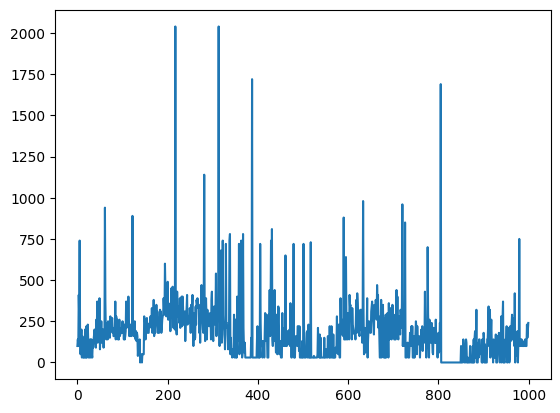

In [13]:
plt.plot(my_scores3)
plt.show() 

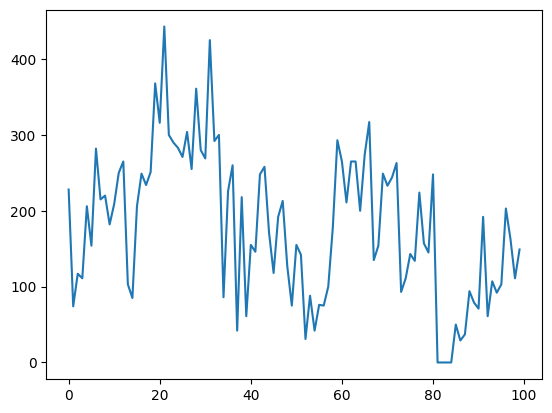

In [14]:
x = [i for i in avg(my_scores3)]
plt.plot(x)
plt.show() 

In [12]:
my_agent4, my_scores4 = my_func(prio= True, DQN=False,n_episodes=1000, ICM=True, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 366.90 58998
Episode 200	Average Score: 398.40 118979
Episode 300	Average Score: 394.00 177075
Episode 400	Average Score: 380.30 236677
Episode 500	Average Score: 379.70 294834
Episode 600	Average Score: 395.50 352052
Episode 700	Average Score: 403.50 412365
Episode 800	Average Score: 384.20 471997
Episode 900	Average Score: 377.80 531854
Episode 1000	Average Score: 389.20 590433


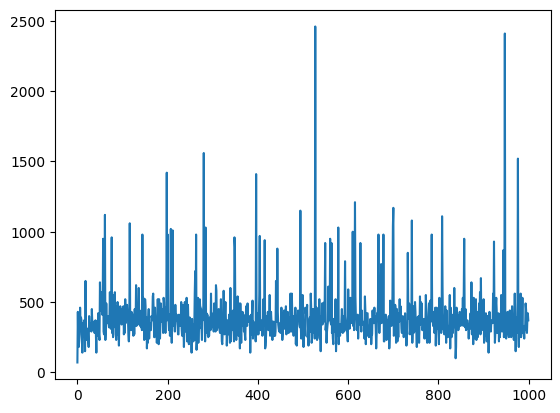

In [13]:
plt.plot(my_scores4)
plt.show() 

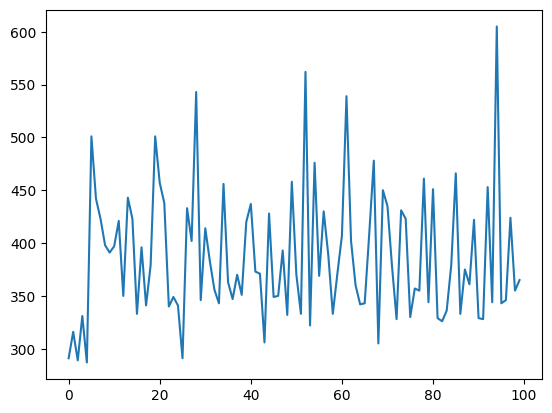

In [14]:
x = [i for i in avg(my_scores4)]
plt.plot(x)
plt.show() 

# ChopperCommandDeterministic

In [15]:
env = gym.make('ChopperCommandDeterministic-v4') 

In [16]:
my_agent1, my_scores1 = my_func(prio= False, DQN=False,n_episodes=1000, ICM=False, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 523.00 40824
Episode 200	Average Score: 519.00 80683
Episode 300	Average Score: 574.00 121476
Episode 400	Average Score: 540.00 161118
Episode 500	Average Score: 564.00 204573
Episode 600	Average Score: 495.00 244691
Episode 700	Average Score: 526.00 285854
Episode 800	Average Score: 473.00 324729
Episode 900	Average Score: 583.00 366923
Episode 1000	Average Score: 478.00 405027


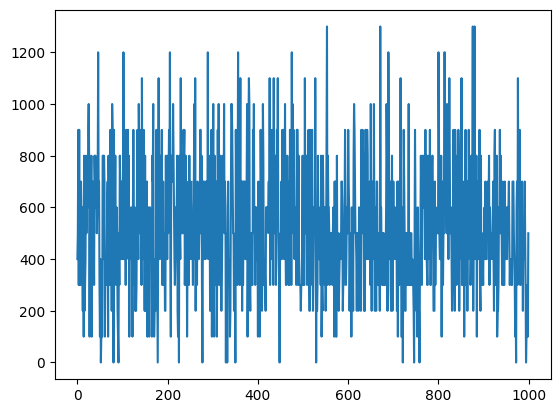

In [17]:
plt.plot(my_scores1)
plt.show() 

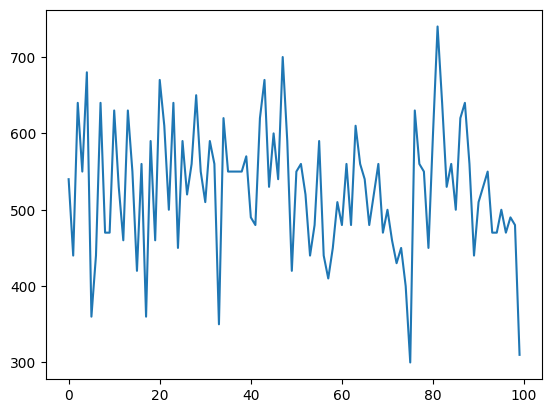

In [18]:
x = [i for i in avg(my_scores1)]
plt.plot(x)
plt.show() 

In [19]:
my_agent2, my_scores2 = my_func(prio= False, DQN=False,n_episodes=1000, ICM=True, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 334.00 35660
Episode 200	Average Score: 522.00 78005
Episode 300	Average Score: 481.00 118806
Episode 400	Average Score: 564.00 164628
Episode 500	Average Score: 534.00 211958
Episode 600	Average Score: 530.00 256738
Episode 700	Average Score: 502.00 305311
Episode 800	Average Score: 526.00 350818
Episode 900	Average Score: 544.00 395745
Episode 1000	Average Score: 485.00 444283


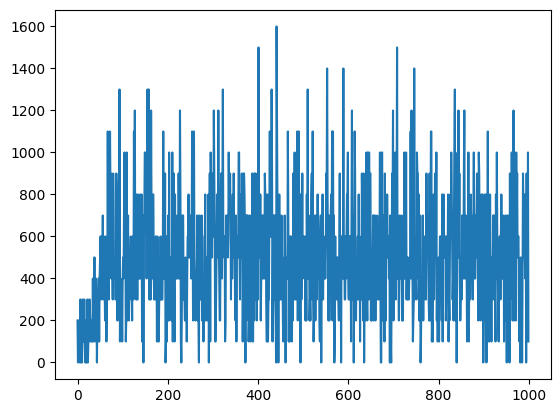

In [20]:
plt.plot(my_scores2)
plt.show() 

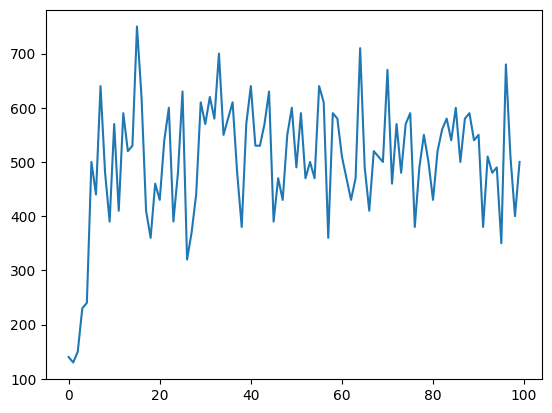

In [21]:
x = [i for i in avg(my_scores2)]
plt.plot(x)
plt.show() 

In [22]:
my_agent3, my_scores3 = my_func(prio= True, DQN=False,n_episodes=1000, ICM=False, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 553.00 37722
Episode 200	Average Score: 842.00 84556
Episode 300	Average Score: 852.00 133655
Episode 400	Average Score: 829.00 184232
Episode 500	Average Score: 936.00 240044
Episode 600	Average Score: 1070.00 295066
Episode 700	Average Score: 950.00 3564680
Episode 800	Average Score: 1066.00 414122
Episode 900	Average Score: 1102.00 467684
Episode 1000	Average Score: 1071.00 528181


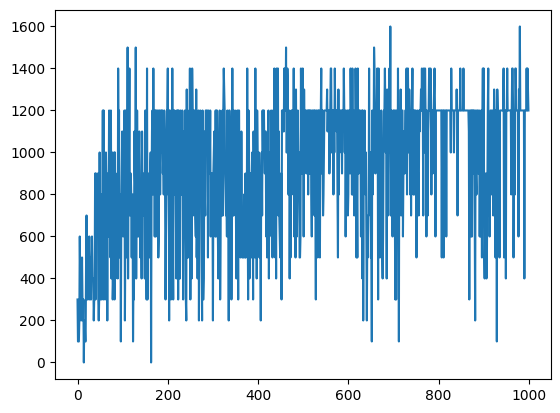

In [23]:
plt.plot(my_scores3)
plt.show() 

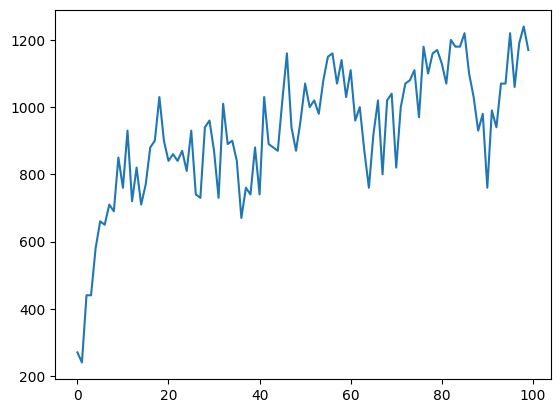

In [24]:
x = [i for i in avg(my_scores3)]
plt.plot(x)
plt.show() 

In [25]:
my_agent4, my_scores4 = my_func(prio= True, DQN=False,n_episodes=1000, ICM=True, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 511.00 39245
Episode 200	Average Score: 543.00 82622
Episode 300	Average Score: 523.00 119577
Episode 400	Average Score: 514.00 160889
Episode 500	Average Score: 483.00 202610
Episode 600	Average Score: 529.00 243660
Episode 700	Average Score: 489.00 285340
Episode 800	Average Score: 552.00 329560
Episode 900	Average Score: 490.00 370996
Episode 1000	Average Score: 605.00 418316


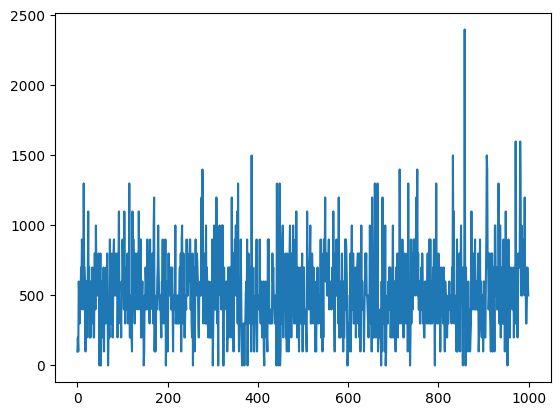

In [26]:
plt.plot(my_scores4)
plt.show() 

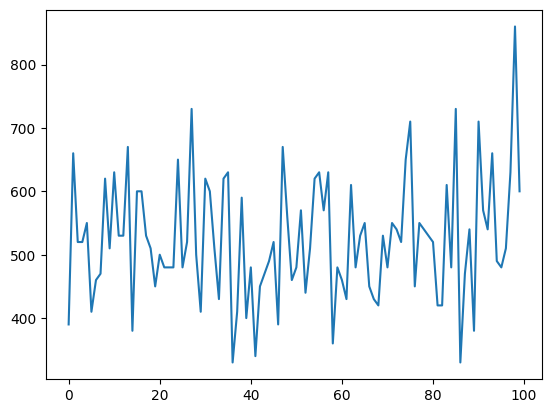

In [27]:
x = [i for i in avg(my_scores4)]
plt.plot(x)
plt.show() 

# BankHeistDeterministic

In [28]:
env = gym.make('BankHeistDeterministic-v4')

In [29]:
my_agent1, my_scores1 = my_func(prio= False, DQN=False,n_episodes=1000, ICM=False, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 18.30 112660
Episode 200	Average Score: 13.60 235595
Episode 300	Average Score: 11.30 341958
Episode 400	Average Score: 14.30 449616
Episode 500	Average Score: 12.70 561179
Episode 600	Average Score: 12.40 672999
Episode 700	Average Score: 13.80 781481
Episode 800	Average Score: 11.00 896070
Episode 900	Average Score: 13.80 1006391
Episode 1000	Average Score: 15.20 1118018


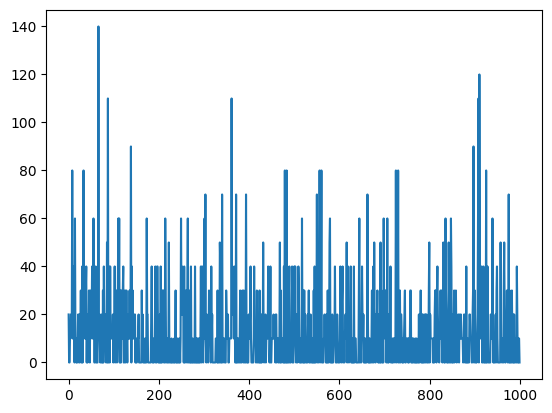

In [30]:
plt.plot(my_scores1)
plt.show() 

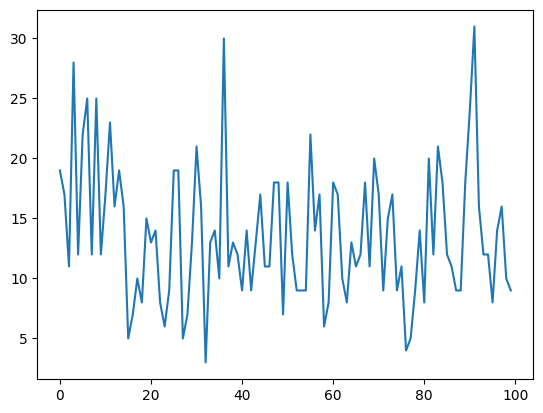

In [31]:
x = [i for i in avg(my_scores1)]
plt.plot(x)
plt.show() 

In [32]:
my_agent2, my_scores2 = my_func(prio= False, DQN=False,n_episodes=1000, ICM=True, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 10.60 88040
Episode 200	Average Score: 11.60 170576
Episode 300	Average Score: 12.20 255693


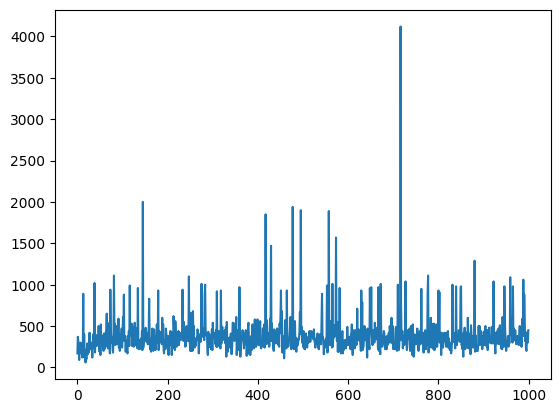

In [ ]:
plt.plot(my_scores2)
plt.show() 

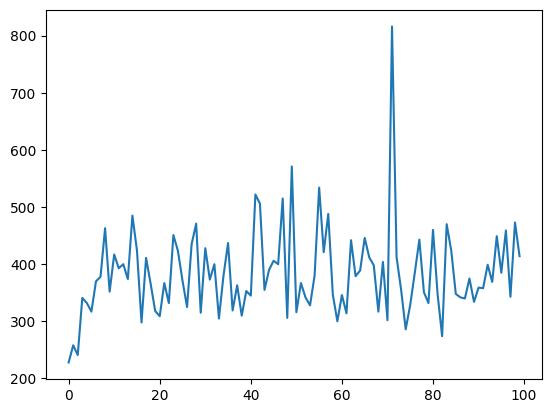

In [ ]:
x = [i for i in avg(my_scores2)]
plt.plot(x)
plt.show() 

In [ ]:
my_agent3, my_scores3 = my_func(prio= True, DQN=False,n_episodes=1000, ICM=False, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 178.90 53038
Episode 200	Average Score: 222.00 106605
Episode 300	Average Score: 310.30 159531
Episode 400	Average Score: 217.90 209324
Episode 500	Average Score: 170.30 258718
Episode 600	Average Score: 118.00 304140
Episode 700	Average Score: 233.50 356347
Episode 800	Average Score: 174.70 407135
Episode 900	Average Score: 53.70 4566570
Episode 1000	Average Score: 125.20 509160


In [ ]:
plt.plot(my_scores3)
plt.show() 

NameError: name 'plt' is not defined

In [ ]:
x = [i for i in avg(my_scores3)]
plt.plot(x)
plt.show() 

NameError: name 'avg' is not defined

In [ ]:
my_agent4, my_scores4 = my_func(prio= True, DQN=False,n_episodes=1000, ICM=True, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

In [ ]:
plt.plot(my_scores4)
plt.show() 

In [ ]:
x = [i for i in avg(my_scores4)]
plt.plot(x)
plt.show() 

# BerzerkDeterministic

In [ ]:
env = gym.make('BerzerkDeterministic-v4')

In [ ]:
my_agent1, my_scores1 = my_func(prio= False, DQN=False,n_episodes=1000, ICM=False, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 332.30 49543
Episode 200	Average Score: 367.20 101193
Episode 300	Average Score: 332.50 155059
Episode 400	Average Score: 353.60 209319
Episode 500	Average Score: 306.10 264656
Episode 600	Average Score: 310.50 317161
Episode 700	Average Score: 366.50 372775
Episode 800	Average Score: 307.10 426629
Episode 900	Average Score: 303.90 480165
Episode 1000	Average Score: 303.40 532414


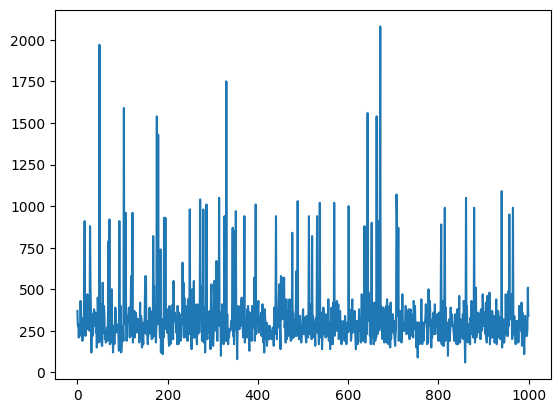

In [ ]:
plt.plot(my_scores1)
plt.show() 

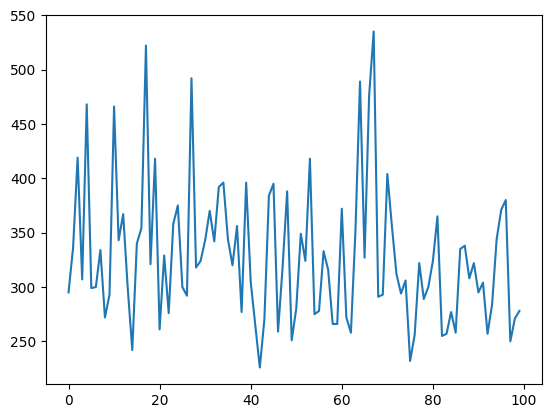

: 

In [ ]:
x = [i for i in avg(my_scores1)]
plt.plot(x)
plt.show() 

In [ ]:
my_agent2, my_scores2 = my_func(prio= False, DQN=False,n_episodes=1000, ICM=True, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 328.00 55256
Episode 200	Average Score: 388.60 116348
Episode 300	Average Score: 379.90 175489
Episode 400	Average Score: 366.80 234459
Episode 500	Average Score: 431.60 294352
Episode 600	Average Score: 382.30 353296
Episode 700	Average Score: 384.70 412056
Episode 800	Average Score: 401.10 471011
Episode 900	Average Score: 371.50 528348
Episode 1000	Average Score: 400.80 589929


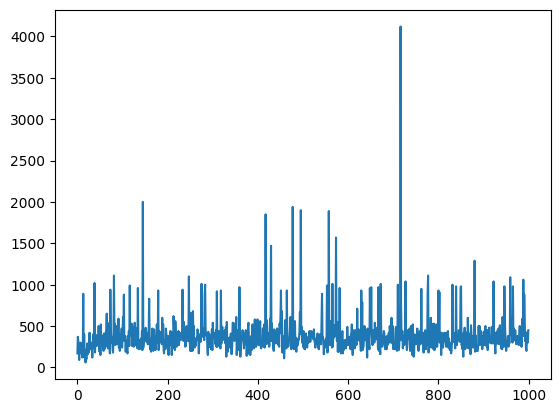

In [ ]:
plt.plot(my_scores2)
plt.show() 

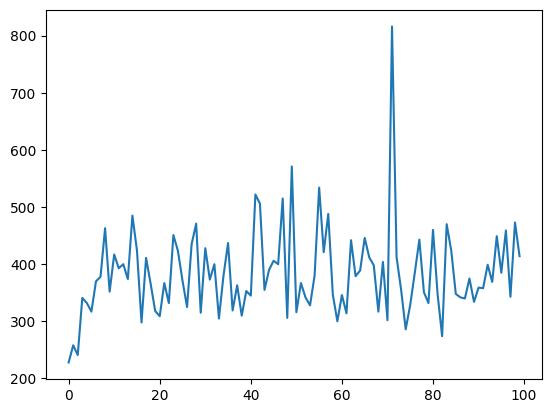

In [ ]:
x = [i for i in avg(my_scores2)]
plt.plot(x)
plt.show() 

In [ ]:
my_agent3, my_scores3 = my_func(prio= True, DQN=False,n_episodes=1000, ICM=False, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

Episode 100	Average Score: 178.90 53038
Episode 200	Average Score: 222.00 106605
Episode 300	Average Score: 310.30 159531
Episode 400	Average Score: 217.90 209324
Episode 500	Average Score: 170.30 258718
Episode 600	Average Score: 118.00 304140
Episode 700	Average Score: 233.50 356347
Episode 800	Average Score: 174.70 407135
Episode 900	Average Score: 53.70 4566570
Episode 1000	Average Score: 125.20 509160


In [ ]:
plt.plot(my_scores3)
plt.show() 

In [ ]:
x = [i for i in avg(my_scores3)]
plt.plot(x)
plt.show() 

In [ ]:
my_agent4, my_scores4 = my_func(prio= True, DQN=False,n_episodes=1000, ICM=True, max_t = 5000, seed=0, LR=0.005, scores_len=100, load=False, save=False)

In [ ]:
plt.plot(my_scores4)
plt.show() 

In [ ]:
x = [i for i in avg(my_scores4)]
plt.plot(x)
plt.show() 